In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

!gcc --version

!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [3]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
%%time
!rm -r frames/*
!mkdir frames/

#specify path to video
video = "sample_input.mp4"

#capture video
cap = cv2.VideoCapture(video)

cnt=0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if(cnt==750):
      break

  # Break the loop
  else: 
    break

mkdir: cannot create directory ‘frames/’: File exists
CPU times: user 1min 2s, sys: 1.78 s, total: 1min 4s
Wall time: 1min 1s


In [5]:
#frame rate of a video
FPS=cap.get(cv2.CAP_PROP_FPS)
print(FPS)

25.0


In [6]:
cfg = get_cfg()

# Download the pre-trained model for object detection from Detectron 2’s model zoo and then the model is ready for inference.
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Find a model from detectron2's model zoo.
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

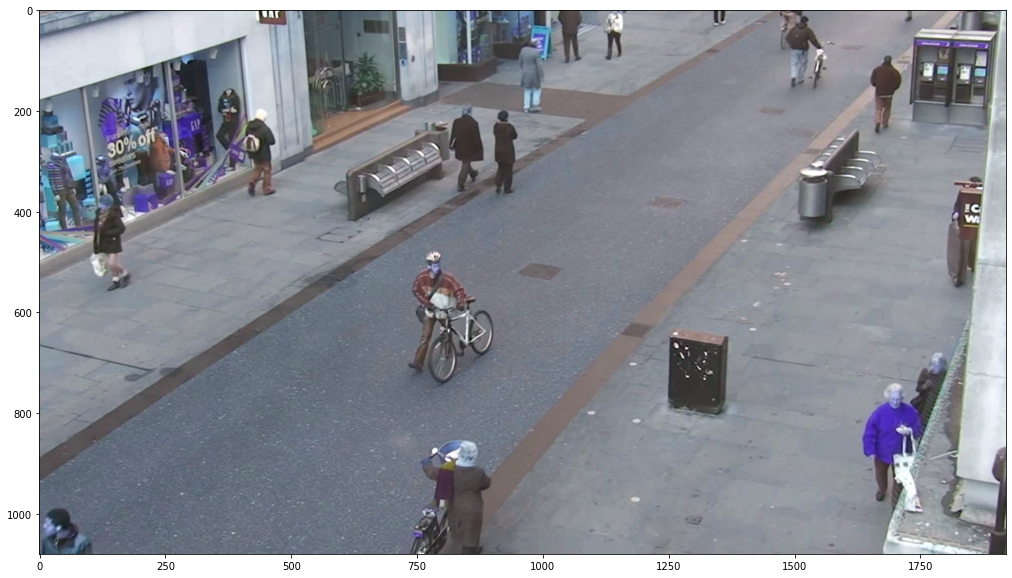

In [7]:
#read an image
img = cv2.imread("frames/30.png")

#pass to the model
outputs = predictor(img)
plt.figure(figsize=(20,10))
plt.imshow(img)

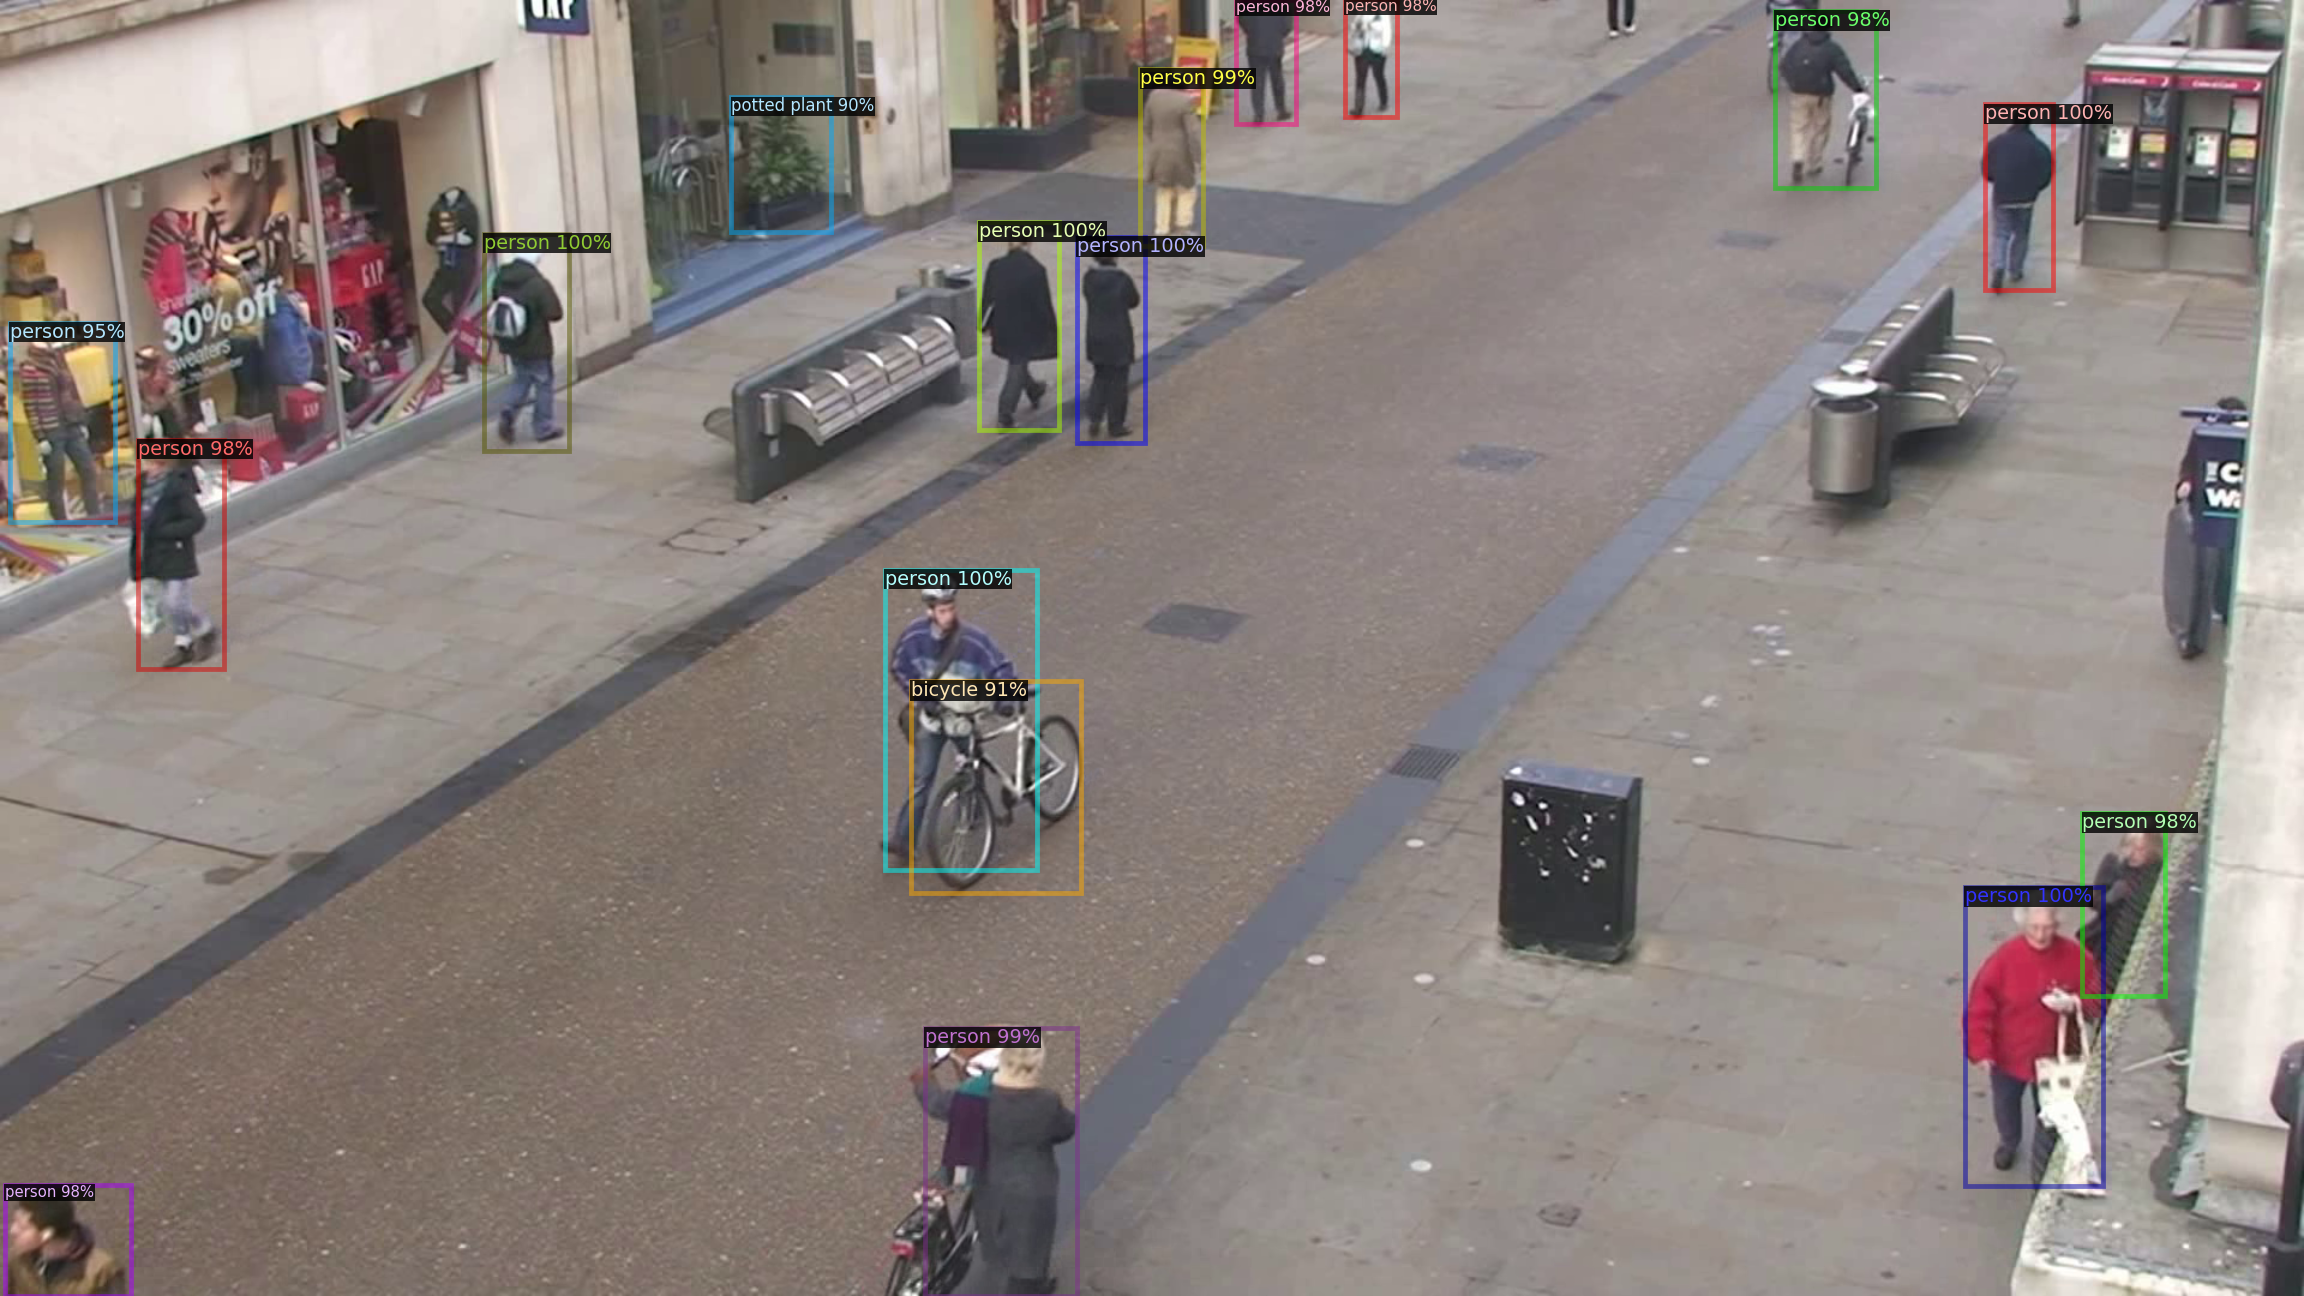

In [8]:
# Use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [9]:
# objects present in an image
classes=outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 58]


In [10]:
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
# print(bbox)

In [11]:
#identity only persons 
ind = np.where(classes==0)[0]

#identify bounding box of only persons
person=bbox[ind]

# person.get_position()
#total no. of persons
num= len(person)

In [12]:
x1,y1,x2,y2 = person[0]
print(x1,y1,x2,y2)

897.62573 198.11475 954.2954 369.93896


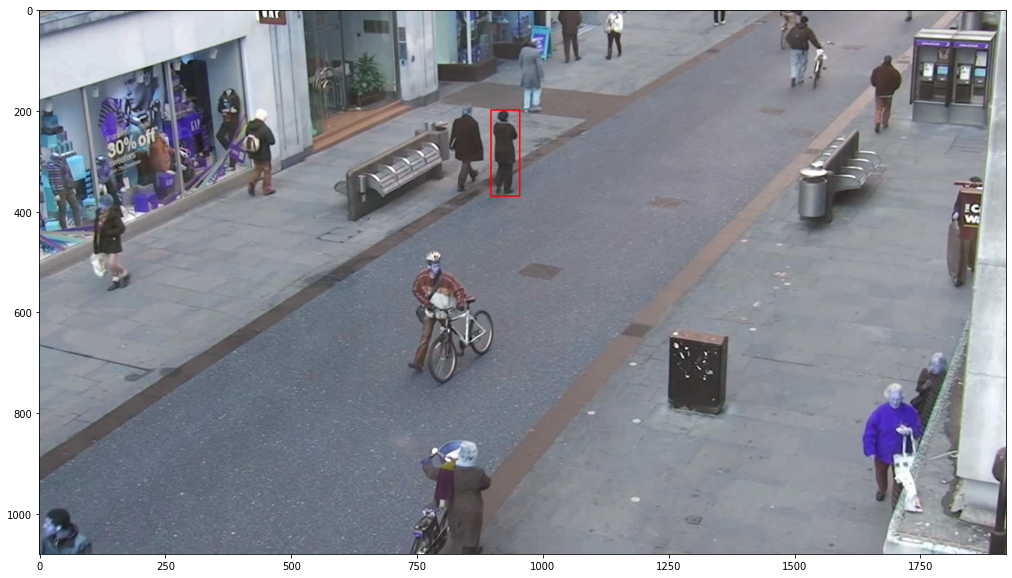

In [13]:
# bounding box for one of the people
img = cv2.imread('frames/30.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

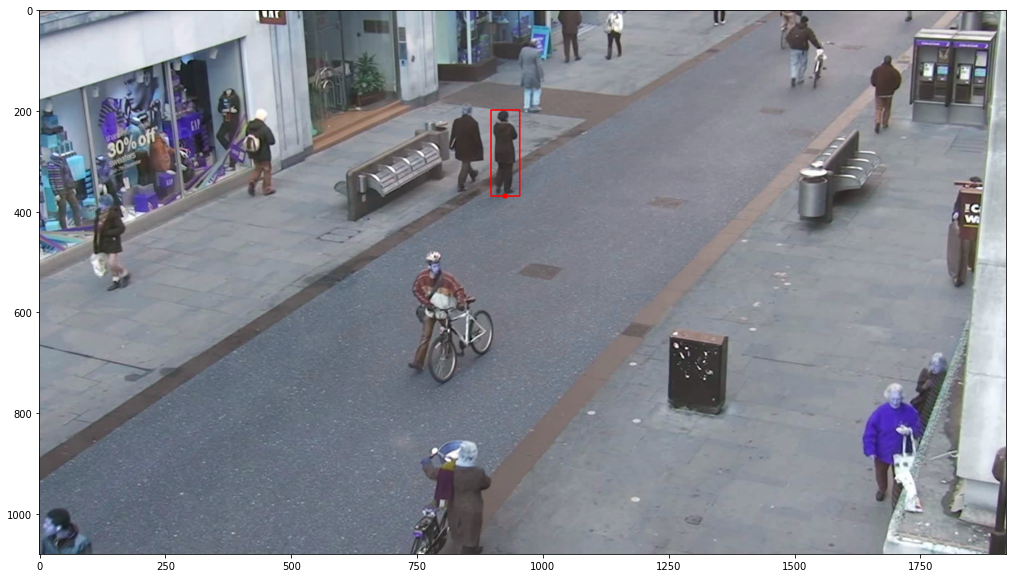

In [14]:
# compute center 
# this measure is invariant of the height of a person
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255, 0, 0), -1)
plt.figure(figsize=(20,10))
plt.imshow(img)

In [15]:
#define a function which return the bottom center of every bbox
def mid_point(img,person,idx):
  
  info = [("Total People",len(person))]
  for (i,(k,v)) in enumerate(info):
    text = "{}:{}".format(k,v)
    cv2.putText(img, text, (10, ((i * 20) + 30)),
			cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

  #get the coordinates
  x1,y1,x2,y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
  
  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (0, 0, 255), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
  
  return mid

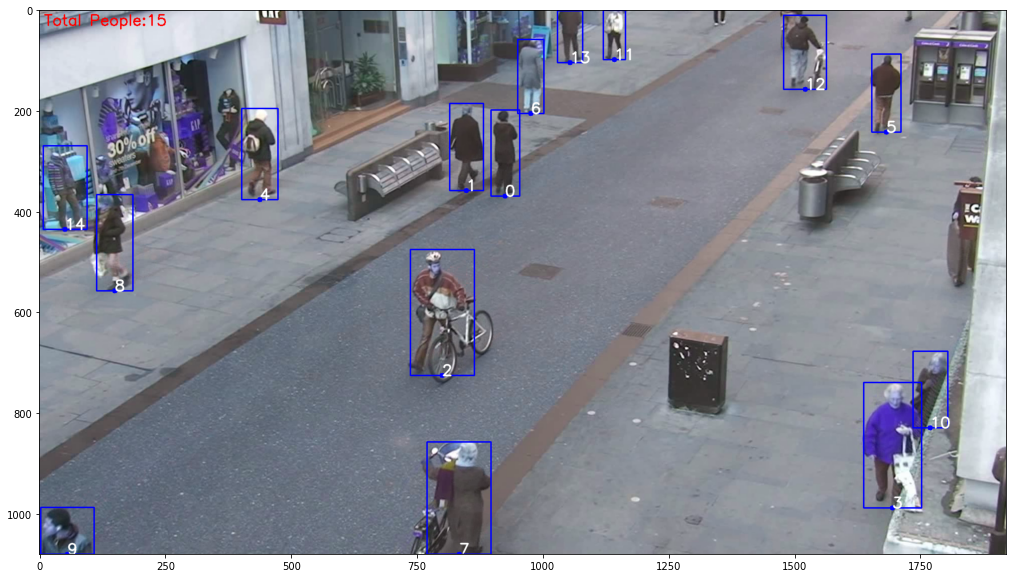

In [16]:
#call the function
midpoints = [mid_point(img,person,i) for i in range(len(person))]

#visualize image
plt.figure(figsize=(20,10))
plt.imshow(img)

In [17]:
# compute the Euclidean distance between every two points in an image
%%time
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

CPU times: user 44.9 ms, sys: 9.99 ms, total: 54.9 ms
Wall time: 56.6 ms


In [18]:
dist= compute_distance(midpoints,num)

In [19]:
# returns the closest people based on the minimum distance between two people
%%time
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [20]:
import pandas as pd

thresh=100
p1,p2,d=find_closest(dist,num,thresh)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
print(df)

   p1  p2       dist
0   0   1  77.781746
1  11  13  88.204308


In [21]:
# change the color of the closest people to red
def change_2_red(img,person,p1,p2,num):
  
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

  info = [("People Prone",len(risky))]
  for (i,(k,v)) in enumerate(info):
    text = "{}:{}".format(k,v)
    cv2.putText(img, text, (10, ((i * 20) + 60)),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
  return img

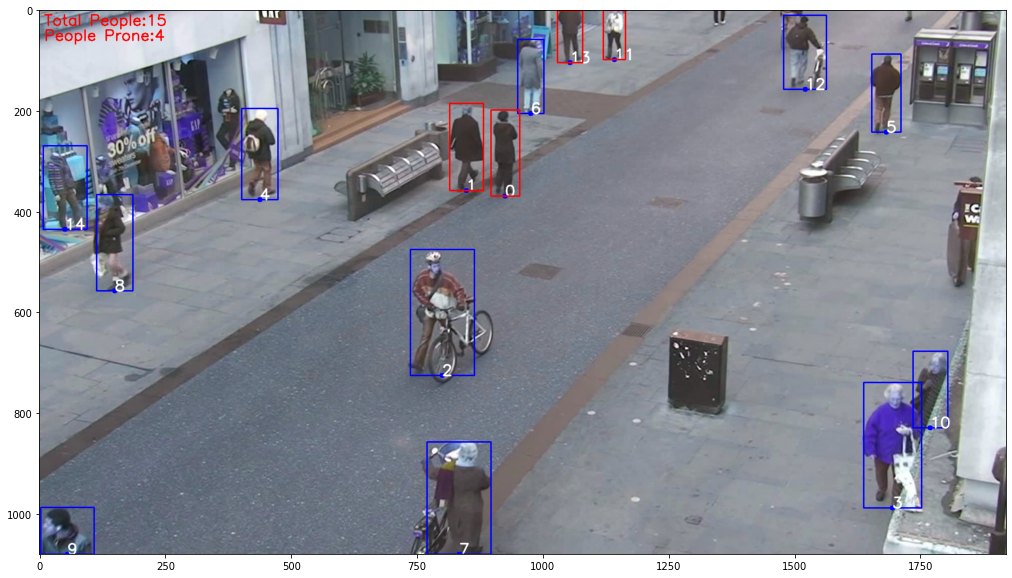

In [22]:
img = change_2_red(img,person,p1,p2,num)

plt.figure(figsize=(20,10))
plt.imshow(img)

In [23]:
# carry out similar steps on every frame of the video now
import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

In [24]:
def find_closest_people(name,thresh):

  img = cv2.imread('frames/'+name)
  outputs = predictor(img)
  classes=outputs['instances'].pred_classes.cpu().numpy()
  bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
  ind = np.where(classes==0)[0]
  person=bbox[ind]
  # print(person)
  midpoints = [mid_point(img,person,i) for i in range(len(person))]
  num = len(midpoints)
  dist= compute_distance(midpoints,num)
  p1,p2,d=find_closest(dist,num,thresh)
  img = change_2_red(img,person,p1,p2,num)
  cv2.imwrite('frames/'+name,img)

  return 0

In [25]:
from tqdm import tqdm
thresh=100
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names))) ]

100%|██████████| 750/750 [07:37<00:00,  1.64it/s]


In [26]:
%%time
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
  
    #reading each files
    img = cv2.imread('frames/'+frames[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('sample_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

CPU times: user 40.6 s, sys: 3.95 s, total: 44.5 s
Wall time: 43.5 s
